<a href="https://colab.research.google.com/github/Atharva-Waghmare/Deep_Learning/blob/main/deep_learning_practice2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from fastai.vision.all import *
path=untar_data(URLs.PETS)

In [ ]:
path.ls()

(#2) [Path('/root/.fastai/data/oxford-iiit-pet/annotations'),Path('/root/.fastai/data/oxford-iiit-pet/images')]

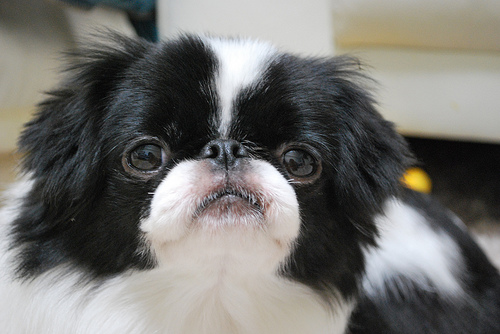

In [ ]:
fname=(path/'images').ls()[0]
Image.open(fname)

In [ ]:
re.findall(r'(.+)_\d+.jpg$', fname.name)

['japanese_chin']

In [ ]:
pets = DataBlock(blocks = (ImageBlock, CategoryBlock),
get_items=get_image_files,
splitter=RandomSplitter(seed=42),
get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
item_tfms=Resize(460),
batch_tfms=aug_transforms(size=224, min_scale=0.75))
dls = pets.dataloaders(path/"images")

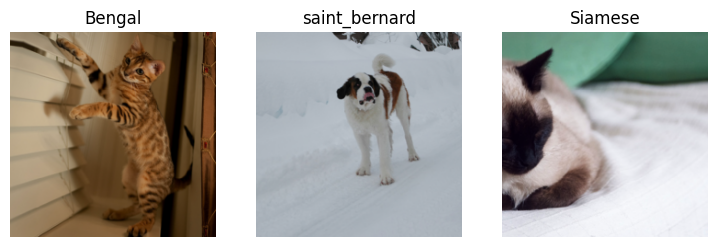

In [ ]:
dls.show_batch(nrows=1,ncols=3)

In [ ]:
learn=cnn_learner(dls,resnet34,metrics=error_rate)
learn.fine_tune(2)

/usr/local/lib/python3.11/dist-packages/fastai/vision/learner.py:303: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 185MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,1.514138,0.321735,0.101489,01:00


epoch,train_loss,valid_loss,error_rate,time
0,0.510665,0.357214,0.096076,01:02
1,0.327865,0.199786,0.057510,01:02


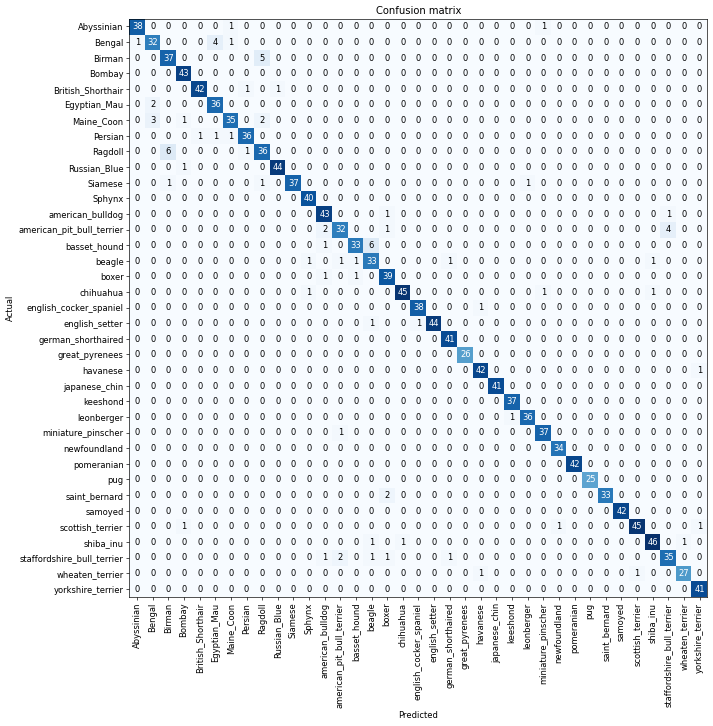

In [ ]:
interp=ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12),dpi=60)

In [ ]:
learn.save('pets_model')

Path('models/pets_model.pth')

ValueError: not enough values to unpack (expected 2, got 1)

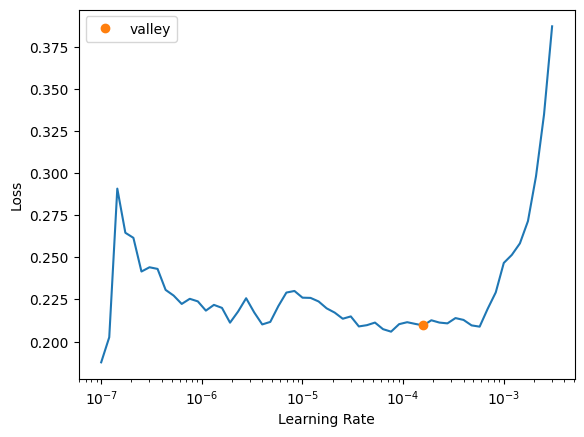

In [ ]:
lr_min,lr_steep=learn.lr_find()

In [ ]:
learn.fine_tune(2,base_lr=2e-4)

epoch,train_loss,valid_loss,error_rate,time
0,0.233697,0.205367,0.056834,00:58


epoch,train_loss,valid_loss,error_rate,time
0,0.225088,0.192626,0.055480,01:01
1,0.208410,0.197170,0.055480,01:02


In [ ]:
learn.fit_one_cycle(3,2e-4)

epoch,train_loss,valid_loss,error_rate,time
0,0.402013,0.543970,0.161028,01:08
1,0.383668,0.256749,0.081191,01:01
2,0.209152,0.236183,0.070365,01:01


SuggestedLRs(valley=4.365158383734524e-05)

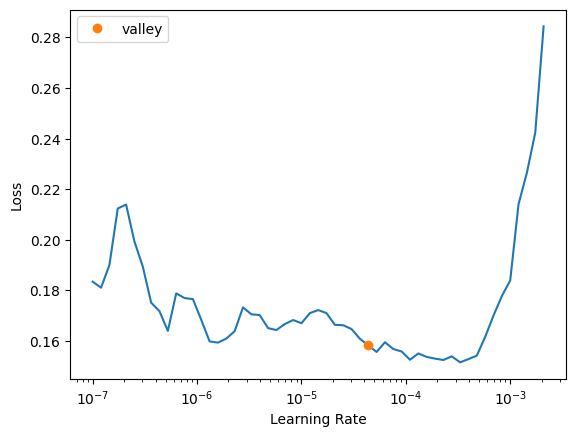

In [ ]:
learn.unfreeze()
learn.lr_find()

In [ ]:
learn.fit_one_cycle(3,1e-4)

epoch,train_loss,valid_loss,error_rate,time
0,0.175101,0.327709,0.106901,01:02
1,0.157759,0.228549,0.063599,01:02
2,0.098219,0.231296,0.062246,01:02


In [ ]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fit_one_cycle(3, 3e-3)
learn.unfreeze()
learn.fit_one_cycle(12, lr_max=slice(1e-6,1e-4))

/usr/local/lib/python3.11/dist-packages/fastai/vision/learner.py:303: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


epoch,train_loss,valid_loss,error_rate,time
0,1.101380,0.320497,0.098106,00:59
1,0.519415,0.247070,0.073072,00:58
2,0.319322,0.219859,0.063599,01:00


epoch,train_loss,valid_loss,error_rate,time
0,0.262517,0.217724,0.060893,01:02
1,0.252761,0.208928,0.059540,01:02
2,0.225360,0.206211,0.060217,01:01
3,0.205784,0.207334,0.062246,01:01
4,0.189773,0.188566,0.054804,01:01
5,0.175210,0.189249,0.058187,01:02
6,0.144625,0.193705,0.053451,01:02
7,0.135852,0.189205,0.052097,01:02
8,0.132204,0.191991,0.052774,01:02
9,0.137794,0.185743,0.050744,01:01


<Axes: title={'center': 'learning curve'}, xlabel='steps', ylabel='loss'>

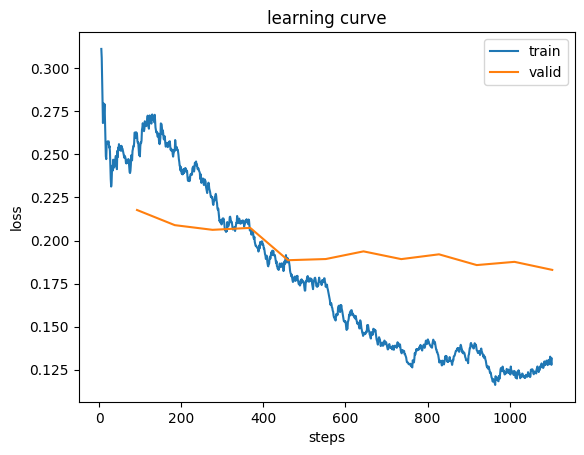

In [ ]:
learn.recorder.plot_loss()

In [ ]:
from fastai.callback.fp16 import *
learn = cnn_learner(dls, resnet50, metrics=error_rate).to_fp16()
learn.fine_tune(3, freeze_epochs=3)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 211MB/s]
/usr/local/lib/python3.11/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/usr/local/lib/python3.11/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


epoch,train_loss,valid_loss,error_rate,time
0,2.186223,0.480723,0.142084,01:01
1,0.836387,0.326582,0.104195,00:59
2,0.556776,0.349385,0.110284,00:59


epoch,train_loss,valid_loss,error_rate,time
0,0.295131,0.270065,0.079161,01:01
1,0.226931,0.240758,0.069689,01:00
2,0.140423,0.204156,0.064953,01:00


In [2]:
from fastai.vision.all import *
path=untar_data(URLs.BIWI_HEAD_POSE)

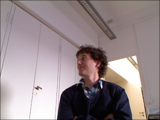

In [5]:
img_files = get_image_files(path)
def img2pose(x): return Path(f'{str(x)[:-7]}pose.txt')
img2pose(img_files[0])
im=PILImage.create(img_files[0])
im.to_thumb(160)

In [6]:
cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6)
def get_ctr(f):
  ctr = np.genfromtxt(img2pose(f), skip_header=3)
  c1 = ctr[0] * cal[0][0]/ctr[2] + cal[0][2]
  c2 = ctr[1] * cal[1][1]/ctr[2] + cal[1][2]
  return tensor([c1,c2])

In [7]:
get_ctr(img_files[0])

tensor([354.0511, 243.0780])

In [8]:
biwi = DataBlock(
blocks=(ImageBlock, PointBlock),
get_items=get_image_files,
get_y=get_ctr,
splitter=FuncSplitter(lambda o: o.parent.name=='13'),
batch_tfms=[*aug_transforms(size=(240,320)),
Normalize.from_stats(*imagenet_stats)]
)

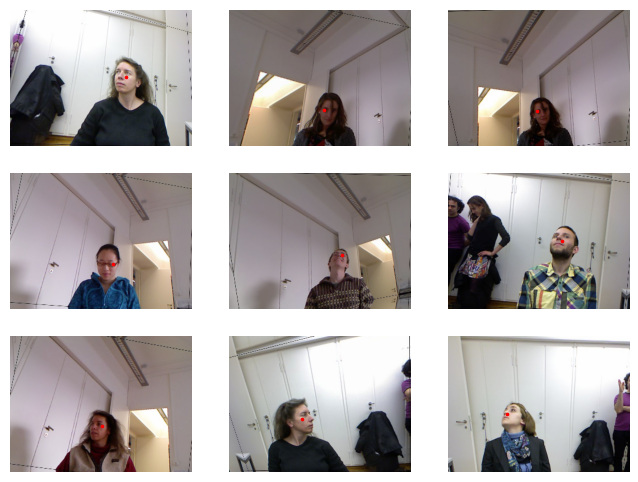

In [9]:
dls = biwi.dataloaders(path)
dls.show_batch(max_n=9, figsize=(8,6))